# Algorithm

Tentative strategic plan (to be verified in the backtesting algo):

5. Optional point: price-book-ratio<1
6. P/E ratio not more than 10% above the min historical P/E ratio
7. P/E ratio (historical over past three years) < 20
8. Positive reaction to quartery report
9. [+1/0] if rating is negative/positive
10. create html file with all stocks and links (onvista, finanzen, yahoo finance)

In [1]:
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import datetime as dt
import time as tt
from QAnT import stock
from QAnT import Index

from scipy.stats import norm
from scipy.stats import levy
import matplotlib.mlab as mlab

# Find companies with empty quote and keyratio tables

## Work with indices [COMPLETE]
Testing ongoing

In [2]:
i = Index(verbose=True,debug=True)

2017-12-04 21:52:13  ^GDAXI        DAX               |deb|  Reading saved quote for all indices
2017-12-04 21:52:15  ^GDAXI        DAX               |deb|  Found 140773 quotes in database
2017-12-04 21:52:15  ^GDAXI        DAX               |deb|  Splitting quote_saved into dictionary


In [3]:
i.ticker, i.name, i._type

('^GDAXI', 'DAX', 'index')

In [4]:
i._download()

2017-12-04 21:52:18  ^GDAXI        DAX               |deb|  Assigning Columns
2017-12-04 21:52:18  ^GDAXI        DAX               |deb|  _prepare_downloaded_quotes_for_saving: Assigning name and ticker columns
2017-12-04 21:52:18  ^GDAXI        DAX               |log|  Successfully loaded index quote for ^GDAXI from yahoo
2017-12-04 21:52:18  ^GDAXI        DAX               |deb|  Finding quotes to save
2017-12-04 21:52:18  ^GDAXI        DAX               |deb|  Found 1 quotes to save
2017-12-04 21:52:18  ^GDAXI        DAX               |deb|  Saving 1 line in sql database
2017-12-04 21:52:20  TMIB.MDD      FTSE MIB          |deb|  Attempts to load TMIB.MDD quote: 1/5
2017-12-04 21:52:22  TMIB.MDD      FTSE MIB          |deb|  Attempts to load TMIB.MDD quote: 2/5
2017-12-04 21:52:24  TMIB.MDD      FTSE MIB          |deb|  Attempts to load TMIB.MDD quote: 3/5
2017-12-04 21:52:24  TMIB.MDD      FTSE MIB          |deb|  Attempts to load TMIB.MDD quote: 4/5
2017-12-04 21:52:26  TMIB.MDD  

2017-12-04 21:53:07  ^ATX          ATX               |deb|  Assigning Columns
2017-12-04 21:53:07  ^ATX          ATX               |deb|  _prepare_downloaded_quotes_for_saving: Assigning name and ticker columns
2017-12-04 21:53:07  ^ATX          ATX               |log|  Successfully loaded index quote for ^ATX from yahoo
2017-12-04 21:53:07  ^ATX          ATX               |deb|  Finding quotes to save
2017-12-04 21:53:07  ^ATX          ATX               |deb|  Found 1 quotes to save
2017-12-04 21:53:07  ^ATX          ATX               |deb|  Saving 1 line in sql database
2017-12-04 21:53:11  000001.SS     SSE Composite Ind |deb|  Assigning Columns
2017-12-04 21:53:11  000001.SS     SSE Composite Ind |deb|  _prepare_downloaded_quotes_for_saving: Assigning name and ticker columns
2017-12-04 21:53:11  000001.SS     SSE Composite Ind |log|  Successfully loaded index quote for 000001.SS from yahoo
2017-12-04 21:53:11  000001.SS     SSE Composite Ind |deb|  Finding quotes to save
2017-12-04

In [5]:
i.quote_saved

{'000001.SS':               date                 name     ticker         open         high  \
 111098  1990-12-19  SSE Composite Index  000001.SS    99.980003    99.980003   
 111099  1990-12-20  SSE Composite Index  000001.SS   104.389999   104.389999   
 111100  1990-12-21  SSE Composite Index  000001.SS   109.129997   109.129997   
 111101  1990-12-24  SSE Composite Index  000001.SS   114.550003   114.550003   
 111102  1990-12-25  SSE Composite Index  000001.SS   120.250000   120.250000   
 111103  1990-12-26  SSE Composite Index  000001.SS   125.269997   125.269997   
 111104  1990-12-27  SSE Composite Index  000001.SS   125.279999   125.279999   
 111105  1990-12-28  SSE Composite Index  000001.SS   126.449997   126.449997   
 111106  1990-12-31  SSE Composite Index  000001.SS   127.610001   127.610001   
 111107  1991-01-02  SSE Composite Index  000001.SS   128.839996   128.839996   
 111108  1991-01-03  SSE Composite Index  000001.SS   130.139999   130.139999   
 111109  1991-0

Determine which lines are to be saved

In [77]:
dax_saved = i.quote_saved['^GDAXI']
dax_saved = dax_saved[0:7500]

In [78]:
len(dax_down), len(dax_saved)

(7561, 7500)

In [79]:
def _extract_unsaved_rows(saved, downloaded):
    '''Identify the rows in the downloaded quote df that shall be saved.'''
    
    # compare the dates between downloaded and saved dates
    s1  = saved['date']
    s2  = downloaded['date']
    
    # dates for which a quote has not yet been saved in the database
    newdates    = np.setdiff1d(s2.values,s1.values)

    # extract the lines to save
    quote_to_save = downloaded[downloaded['date'].isin(newdates)]

    #     self.debug_message("Found {0} quotes to save".format(len(quote_to_save)))
#     self.quote_to_save = quote_to_save
    return quote_to_save

In [80]:
_extract_unsaved_rows(dax_saved,dax_down)

,date,name,ticker,open,high,low,close,volume
7665,2017-09-06,DAX,^GDAXI,12071.900391,12260.759766,12066.839844,12214.540039,83032800.0
7666,2017-09-07,DAX,^GDAXI,12284.139648,12363.599609,12265.509766,12296.629883,93698400.0
7667,2017-09-08,DAX,^GDAXI,12261.809570,12321.610352,12245.330078,12303.980469,61395700.0
7668,2017-09-11,DAX,^GDAXI,12381.519531,12481.769531,12381.330078,12475.240234,76820300.0
7669,2017-09-12,DAX,^GDAXI,12527.440430,12558.030273,12512.589844,12524.769531,85086300.0
7670,2017-09-13,DAX,^GDAXI,12489.250000,12565.849609,12489.250000,12553.570313,79884400.0
7671,2017-09-14,DAX,^GDAXI,12524.120117,12552.160156,12499.549805,12540.450195,83038500.0
7672,2017-09-15,DAX,^GDAXI,12525.360352,12561.349609,12506.940430,12518.809570,192005900.0
7673,2017-09-18,DAX,^GDAXI,12593.549805,12613.559570,12537.070313,12559.389648,58346600.0
7674,2017-09-19,DAX,^GDAXI,12556.459961,12566.200195,12527.900391,12561.790039,74220900.0


In [17]:
for k in i._downl_quotes.keys():
    df = i._downl_quotes[k]
    cnx         = sqlite3.connect('TEST_stocks_quotes.db')
    df.to_sql('indices',cnx,if_exists='append',index=False)
    cnx.close()    

In [19]:
def convert_sql_date_to_datetime_date(string):
    return dt.datetime.strptime(string,'%Y-%m-%d').date()

In [38]:
cnx          = sqlite3.connect('TEST_stocks_quotes.db')
quote_saved  = pd.read_sql_query("SELECT * FROM indices;", cnx)
quote_saved['date'] = quote_saved.date.apply(convert_sql_date_to_datetime_date)
cnx.close()

quote_saved_dict = {}
for k in np.unique(quote_saved['ticker']):
    quote_saved_dict[k] = quote_saved[quote_saved['ticker']==k]

In [45]:
len(quote_saved_dict.keys())

26

# Perform the analysis

In [3]:
s = stock(verbose=True, debug=True, isin='US3755581036')
# s.switch_isin('US3755581036')

2017-11-28 22:20:04  US3755581036  GILEAD SCIENCES   |deb|  Switched to new stock: GILEAD SCIENCES   DL-,001
2017-11-28 22:20:04  US3755581036  GILEAD SCIENCES   |deb|  ISIN & Ticker:         US3755581036, GILD
2017-11-28 22:20:04  US3755581036  GILEAD SCIENCES   |log|  Reading saved quote for stock GILEAD SCIENCES   DL-,001
2017-11-28 22:20:05  US3755581036  GILEAD SCIENCES   |log|  Reading saved quote for stock GILEAD SCIENCES   DL-,001


In [6]:
s.get_summary(save=True)

2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Earnings Growth: 0.2990143070858493
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Checking dividend growth
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Latest dividend 1.33
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Previous dividend nan
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Calculating fair price from P/E ratio
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Selected quantile: 0.5
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Connected to sqlite database algo_results.db
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Removing old output
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Adding new result
2017-11-28 22:20:20  US3755581036  GILEAD SCIENCES   |log|  Completed get_summary


In [7]:
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,"GILEAD SCIENCES DL-,001",US3755581036,OnlyPositiveEarnings,0,1
1,"GILEAD SCIENCES DL-,001",US3755581036,AnnualEarningsGrowth,29.9,1
2,"GILEAD SCIENCES DL-,001",US3755581036,BookValueGrowth,658.7,1
3,"GILEAD SCIENCES DL-,001",US3755581036,HistoricROE,29.7,1
4,"GILEAD SCIENCES DL-,001",US3755581036,PresentROE,72.2,1
5,"GILEAD SCIENCES DL-,001",US3755581036,PresentRoIC,33.2,1
6,"GILEAD SCIENCES DL-,001",US3755581036,EquityRatio,33.1,1
7,"GILEAD SCIENCES DL-,001",US3755581036,EBTMargin,56.3,1
8,"GILEAD SCIENCES DL-,001",US3755581036,DividendGrowth,nan,0
9,"GILEAD SCIENCES DL-,001",US3755581036,SixMonthReturn,11.7,1


In [8]:
def convert_sql_date_to_datetime_date(string):
    return dt.datetime.strptime(string,'%Y-%m-%d').date()

# Check returns and volatility

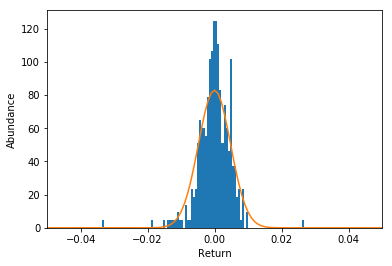

In [25]:
# daily_return = np.diff(s.quote['close'])/s.quote['close'][1:]
daily_return = s.volatility['return']
(mu, sigma) = norm.fit(daily_return)

plt.hist(daily_return,bins=100,normed=True)
xvals = np.arange(-0.1,0.1,0.001)
plt.plot(xvals, mlab.normpdf( xvals, mu, sigma))
plt.xlim(-0.05,0.05)
plt.xlabel("Return")
plt.ylabel("Abundance")
plt.show()

In [13]:
a,b = levy.fit(daily_return)

/home/phermes/.conda/envs/py36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning:

invalid value encountered in double_scalars



function to get monthly volatility 

In [78]:
dt.date.today()- dt.timedelta(360), dt.date.today()

(datetime.date(2016, 11, 29), datetime.date(2017, 11, 24))

In [16]:
date_lower  = dt.date.today() - dt.timedelta(360)
date_upper  = dt.date.today()
quote_month = quote[(quote['date']>date_lower) & (quote['date']<date_upper)]

In [108]:
voladata = get_returns_var_vola(quote,100)

In [20]:
lk = 0
lq = 0
while (lk==0) or (lq==0):
    s.switch_next()
    lk, lq = len(s.keyratios), len(s.quote)

2017-11-28 22:24:43  AU000000GBG5  GINDALBIE METALS  |log|  Reading saved quote for stock GINDALBIE METALS LTD.
2017-11-28 22:24:43  BMG6901M1010  GIORDANO INTL     |log|  Reading saved quote for stock GIORDANO INTL      HD-,05
2017-11-28 22:24:44  DE0005880405  Girindus          |log|  Reading saved quote for stock Girindus
2017-11-28 22:24:44  GB0030646508  GKN PLC           |log|  Reading saved quote for stock GKN PLC          LS -,10


In [21]:
lk, lq

(11, 7561)

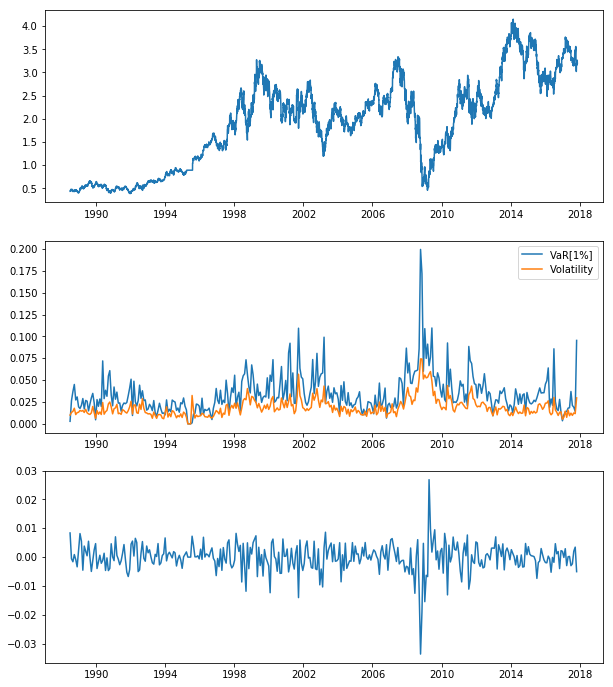

In [23]:
quote = s.quote
# voladata = get_returns_var_vola(s.quote,30)
voladata = s.volatility
fig = plt.figure(figsize=[10,12])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312,sharex=ax1)
ax3 = fig.add_subplot(313,sharex=ax1)

ax3.plot(voladata['date'], voladata['return'],'-')
ax2.plot(voladata['date'], voladata['var'], label='VaR [1%]')
ax2.plot(voladata['date'], voladata['vola'], label='Volatility')
ax2.legend()
ax1.plot(quote['date'], quote['close'])
# ax1.set_xlim(dt.date.today()- dt.timedelta(360), dt.date.today())
# ax3.set_ylim(-0.1,0.1)
# ax1.set_ylim(60,90)
# ax1.set_yscale('log')
# ax2.set_yscale('log')
plt.show()

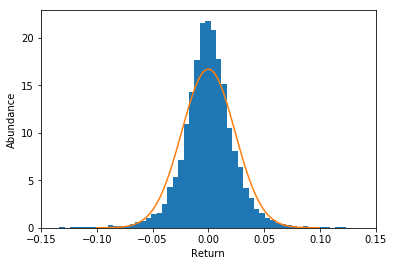

In [112]:
daily_return = np.diff(s.quote['close'])/s.quote['close'][1:]
(mu, sigma) = norm.fit(daily_return)
plt.hist(daily_return,bins=100,normed=True)
xvals = np.arange(-0.1,0.1,0.001)
plt.plot(xvals, mlab.normpdf( xvals, mu, sigma))
plt.xlim(-0.15,0.15)
plt.xlabel("Return")
plt.ylabel("Abundance")
plt.show()

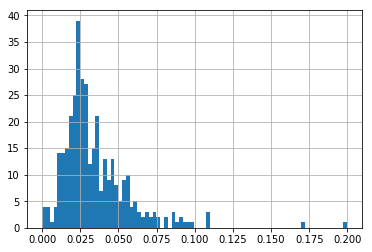

In [26]:
voladata['var'].hist(bins=80)
plt.show()

In [48]:
from stocks.risk import get_returns_var_vola
retvar = get_returns_var_vola(s.quote,50)

In [51]:
retvar = get_returns_var_vola(s.quote,10)

In [58]:
from stocks.risk import _get_return_individual

In [61]:
_get_return_individual(s.quote,10,1)

(datetime.date(2017, 10, 31),
 (0.0045246634275055483, 0.008354672387111583, 0.011150916578753865))

In [62]:
r           = np.diff(s.quote['close'])/s.quote['close'][1:]

In [71]:
plt.plot()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (7559,) and (1,)

In [70]:
len(r[1:]), len(r[:-1])

(7559, 7559)

In [72]:
r[:-1], r[:1]

(1       0.003204
 2       0.018797
 3       0.000000
 4      -0.003131
 5       0.006246
 6       0.024396
 7       0.006057
 8       0.000000
 9       0.019776
 10      0.009832
 11     -0.017974
 12     -0.006020
 13      0.003012
 14     -0.012172
 15     -0.021736
 16     -0.006246
 17     -0.003144
 18      0.009322
 19      0.015292
 20      0.000000
 21      0.023886
 22      0.000000
 23      0.002964
 24      0.014664
 25      0.005827
 26     -0.002912
 27     -0.017867
 28     -0.027516
 29      0.000000
 30      0.012077
           ...   
 7530    0.009335
 7531    0.009249
 7532    0.006889
 7533    0.002291
 7534    0.013559
 7535    0.001410
 7536    0.004213
 7537   -0.008499
 7538   -0.003411
 7539    0.002834
 7540   -0.109434
 7541   -0.035493
 7542   -0.003595
 7543    0.002282
 7544   -0.015227
 7545    0.004285
 7546    0.048903
 7547    0.003125
 7548   -0.014585
 7549    0.003161
 7550    0.013408
 7551   -0.001874
 7552   -0.009779
 7553    0.006581
 7554    0

# Reaction to quarterly report

In [7]:
today          = dt.date.today()
six_months_ago = today - dt.timedelta(days=182)

In [65]:
latest_quote/quote_six_months_ago

1.1899293636610531

In [6]:
today, six_months_ago

(datetime.date(2017, 11, 1), datetime.date(2017, 5, 3))

In [35]:
s.quote[s.quote['date'] == six_months_ago]['close']

6346    67.919998
Name: close, dtype: float64

In [ ]:
np.isin(s.quote['date'])

In [8]:
for i in s.keyratios.columns:
    print(i)

name
ISIN
currency
year
Shares
Revenue
NetIncome
EBTMargin
EarningsPerShare
Dividends
TotalStockholdersEquity
ReturnonEquity
BookValuePerShare
OperatingCashFlow
GrossMargin
OperatingIncome
OperatingMargin
CapSpending
FreeCashFlow
FreeCashFlowPerShare
WorkingCapital
COGS
TaxRate
NetMargin
AssetTurnoverAverage
ReturnonAssets
FinancialLeverageAverage
ReturnonInvestedCapital
InterestCoverage


In [6]:
def get_proper_ticker(string):
#     print(string)
    try:
        return string.split('.')[0]
    except AttributeError:
        return np.nan

In [7]:
df = pd.read_csv('StockList.new',
                 delim_whitespace=True, 
                 usecols=[0,1,2,4,5,6,7],
                 names=['name1','isin','finanzen.net','onvista','ticker_YF','benchmark','fin1'])

In [8]:
cnx        = sqlite3.connect('database/stocks_main_old.db')
xetra      = pd.read_sql("SELECT * FROM XETRA;", cnx)

In [9]:
xetra.columns = ['name2','isin','ticker_MS','fin2']

In [10]:
dfnew = df.merge(xetra,on='isin',how='outer')

In [12]:
dfnew = dfnew[['name1','name2','isin','ticker_YF','ticker_MS','benchmark','onvista','finanzen.net','fin1']]

In [179]:
# dfnew['ticker_YF'] = dfnew['ticker_YF'].replace("NaN",np.nan, regex=True)

In [16]:
dfnew.head()

,name1,name2,isin,ticker_YF,ticker_MS,benchmark,onvista,finanzen.net,fin1
0,A2A,NaN,IT0001233417,EAM,NaN,FTMIB.MDD,A2A-S-P-A-Aktie-IT0001233417,A2A,0.0
1,Aareal_Bank,AAREAL BANK AG,DE0005408116,ARL,ARL,^GDAXI,Aareal-Bank-Aktie-DE0005408116,Aareal_Bank,1.0
2,ABB_1,"ABB LTD ADR/1 SF 2,50",US0003752047,ABJA,ABJA,^GSPC,ABB-LTD-Aktie-US0003752047,ABB_1,0.0
3,ABB,"ABB LTD. NA SF 0,12",CH0012221716,ABJ,ABJ,^SSMI,ABB-Aktie-CH0012221716,ABB,0.0
4,Abbott_Laboratories,ABBOTT LABS,US0028241000,ABL,ABL,^GSPC,ABBOTT-LABORATORIES-Aktie-US0028241000,Abbott_Laboratories,0.0


In [15]:
dfnew['ticker_YF'] = dfnew['ticker_YF'].apply(get_proper_ticker)

/home/phermes/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [17]:
dfnew['name2'].fillna(dfnew['name1'], inplace=True)    # fill the names which are not filled by the other names

/home/phermes/.conda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [183]:
# dfnew['ticker_YF'].fillna(dfnew['ticker_MS'], inplace=True)

In [184]:
# dfnew['ticker_MS'].fillna(dfnew['ticker_YF'], inplace=True)

In [18]:
dfnew.tail()

,name1,name2,isin,ticker_YF,ticker_MS,benchmark,onvista,finanzen.net,fin1
2882,NaN,S+P GLOBAL INC. DL 1,US78409V1044,NaN,MHL,NaN,NaN,NaN,NaN
2883,NaN,"SELECTA BIOSCI. DL -,0001",US8162121045,NaN,1S7,NaN,NaN,NaN,NaN
2884,NaN,TAILORED BRANDS INC.DL-01,US87403A1079,NaN,WRM,NaN,NaN,NaN,NaN
2885,NaN,TEGNA INC. DL 1,US87901J1051,NaN,GTT,NaN,NaN,NaN,NaN
2886,NaN,"TIVITY HEALTH DL-,001",US88870R1023,NaN,AFN,NaN,NaN,NaN,NaN


In [76]:
dfnew[(dfnew['ticker_YF'] != dfnew['ticker_MS']) & (dfnew['ticker_MS'].notnull())& (dfnew['ticker_YF'].notnull())]

,name1,name2,isin,ticker_YF,ticker_MS,benchmark,onvista,finanzen.net,fin1
169,Apple,APPLE INC.,US0378331005,APC,AAPL,^GSPC,Apple-Aktie-US0378331005,Apple,0.0
185,Ariad_Pharmaceuticals,ARIAD PHARMACEUTICALS,US04033A1007,APS,ARIA,^GSPC,ARIAD-PHARMA-Aktie-US04033A1007,Ariad_Pharmaceuticals,0.0
274,Baker_Hughes,BAKER HUGHES INC. DL 1,US0572241075,BHU,68V,^GSPC,BAKER-HUGHES-INCORPORATED-Aktie-US0572241075,Baker_Hughes,0.0
451,Caltex_Australia,CALTEX AUSTRALIA,AU000000CTX1,CLZ,CTX,^AORD,CALTEX-AUSTRALIA-Aktie-AU000000CTX1,Caltex_Australia,0.0
484,Carrefour,"CARREFOUR S.A. INH.EO 2,5",FR0000120172,CAR,CA,^FCHI,Carrefour-Aktie-FR0000120172,Carrefour,0.0
1733,Nestle,NESTLE,CH0038863350,NESR,NESN,^SSMI,Nestle-Aktie-CH0038863350,Nestlé,0.0
1886,Orthofix_International,"ORTHOFIX INT. DL-,10",ANN6748L1027,OFX,OFIX,XWD.TO,None,Orthofix_International,0.0
2011,Porta_Systems,ELANIX BIOTECHN.AG,DE000A0WMJQ4,PFTA,ELN,^GDAXI,PORTA-SYSTEMS-AG-Aktie-DE000A0WMJQ4,Porta_Systems,0.0
2036,PrivateBancorp,PRIVATEBANCORP INC.,US7429621037,TPB,PVTB,^GSPC,PRIVATEBANCORP-Aktie-US7429621037,PrivateBancorp,0.0
2038,ProcterGamble,PROCTER GAMBLE,US7427181091,PRG,PG,^GSPC,Procter-Gamble-Aktie-US7427181091,ProcterGamble,0.0


In [186]:
dfnew = dfnew[['name2','isin','ticker_YF','ticker_MS','benchmark','onvista','finanzen.net','fin1']]

In [192]:
dfnew.columns = ['name','isin','ticker_YF','ticker_MS','benchmark','onvista','finanzen.net','branch']

In [193]:
cnx        = sqlite3.connect('database/stocks_main2.db')
dfnew.to_sql('xetra',cnx,index=False)

In [25]:
yflist  = pd.read_csv('/home/phermes/stocks.csv')

In [27]:
yflist = yflist.dropna(thresh=4)

In [30]:
ydflist['Ticker'] = ydflist['Ticker'].apply(get_proper_ticker)

In [31]:
ydflist

,Ticker,Name,Exchange,categoryName
1,LIN,LINDE AG O.N.,HAN,Chemicals - Major Diversified
3,HEB,"Hemispherx Biopharma, Inc.",ASE,Biotechnology
4,QSC,QSC AG NA O.N.,BER,Wireless Communications
10,0845,Glorious Property Holdings Limited,HKG,Real Estate Development
11,SGMO,"Sangamo Therapeutics, Inc.",NMS,Biotechnology
14,0896,Hanison Construction Holdings Limited,HKG,General Contractors
17,ELET3,Centrais Elétricas Brasileiras S.A. - Eletrobras,SAO,Electric Utilities
21,SIEN,Siemens Aktiengesellschaft,MEX,Diversified Machinery
23,SPR,"Spirit AeroSystems Holdings, Inc.",NYQ,Aerospace/Defense Products & Services
32,FVI,Fair Value REIT-AG,GER,REIT - Diversified


In [126]:
test = dfnew.tail()

In [136]:
test.ticker_YF.fillna(test.ticker_MS)

2882    NaN
2883    NaN
2884    NaN
2885    NaN
2886    NaN
Name: ticker_YF, dtype: object

In [140]:
dfnew['ticker_YF'].tail()[2886]

'NaN'

In [142]:
test = test.replace("NaN",np.nan, regex=True)

In [143]:
test.ticker_YF.fillna(test.ticker_MS)

2882    MHL
2883    1S7
2884    WRM
2885    GTT
2886    AFN
Name: ticker_YF, dtype: object

## Try to identify the correct company by its name 

In [34]:
from difflib import get_close_matches

In [59]:
get_close_matches('Daimler', ydflist['Name'].tolist(), cutoff=0.4)

['Daimler AG', 'Daimler AG', 'Damaris SA']

In [44]:
get_close_matches?

In [41]:
ydflist['Name'].tolist()

['LINDE AG O.N.',
 'Hemispherx Biopharma, Inc.',
 'QSC AG NA O.N.',
 'Glorious Property Holdings Limited',
 'Sangamo Therapeutics, Inc.',
 'Hanison Construction Holdings Limited',
 'Centrais Elétricas Brasileiras S.A. - Eletrobras',
 'Siemens Aktiengesellschaft',
 'Spirit AeroSystems Holdings, Inc.',
 'Fair Value REIT-AG',
 'Sparton Corporation',
 'Spectrum Brands Holdings, Inc.',
 'Münchener Rückversicherungs-Gesellschaft Aktiengesellschaft',
 'Simon Property Group, Inc.',
 'XPO Logistics, Inc.',
 'Richelieu Hardware Ltd.',
 'Solitario Zinc Corp.',
 'Cordy Oilfield Services Inc.',
 'Grenke AG',
 'Vivendi SA',
 'Cornerstone Capital Resources Inc.',
 'JBS S.A.',
 'Dunelm Group plc',
 'Clean Diesel Technologies, Inc.',
 'First Resources Limited',
 'National Western Life Group, Inc.',
 'Juniper Pharmaceuticals, Inc.',
 'Ultima United Limited',
 'Electrovaya Inc.',
 'Johnson & Johnson',
 'AGT Food and Ingredients Inc.',
 'RHEINMETALL AG',
 'Franklin Resources, Inc.',
 'Belmond Ltd.',
 'Dis

In [76]:
cnx        = sqlite3.connect('database/stocks_main2.db')
# xetra      = pd.read_sql("SELECT * FROM XETRA;", cnx)
dfnew.to_sql('xetra',cnx)

In [9]:
s.switch_isin('US3755581036')

Reading saved quote for stock GILEAD SCIENCES   DL-,001


In [18]:
s.get_quote(download=True, save=True)

ValueError: time data '' does not match format '%Y-%m-%d'

In [20]:
s.quote['date']

0       2000-01-10
1       2000-01-11
2       2000-01-12
3       2000-01-13
4       2000-01-14
5       2000-01-17
6       2000-01-18
7       2000-01-19
8       2000-01-20
9       2000-01-21
10      2000-01-24
11      2000-01-25
12      2000-01-26
13      2000-01-27
14      2000-01-28
15      2000-01-31
16      2000-02-01
17      2000-02-02
18      2000-02-03
19      2000-02-04
20      2000-02-07
21      2000-02-08
22      2000-02-09
23      2000-02-10
24      2000-02-11
25      2000-02-14
26      2000-02-15
27      2000-02-16
28      2000-02-17
29      2000-02-18
           ...    
4540    2017-08-07
4541    2017-08-08
4542    2017-08-09
4543    2017-08-10
4544    2017-08-11
4545    2017-08-14
4546    2017-08-15
4547    2017-08-16
4548    2017-08-17
4549    2017-08-18
4550    2017-08-21
4551    2017-08-22
4552    2017-08-23
4553    2017-08-24
4554    2017-08-25
4555    2017-08-28
4556    2017-08-29
4557    2017-08-30
4558    2017-08-31
4559    2017-09-01
4560    2017-09-04
4561    2017

In [10]:
s.get_summary(save=False)
s.quant_result

,Name,ISIN,Parameter,Value,Point
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,OnlyPositiveEarnings,0,1
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,AnnualEarningsGrowth,11.6,1
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,HistoricROE,23.8,1
3,FUCHS PETROL.SE VZO O.N.,DE0005790430,PresentROE,22.8,1
4,FUCHS PETROL.SE VZO O.N.,DE0005790430,EquityRatio,71.8,1
5,FUCHS PETROL.SE VZO O.N.,DE0005790430,EBTMargin,16.3,1
6,FUCHS PETROL.SE VZO O.N.,DE0005790430,DividendGrowth,316.4,1


In [11]:
s.interactive_summary()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



In [12]:
cnx        = sqlite3.connect('output/algo_results.db')
results    = pd.read_sql("SELECT * FROM summary;", cnx)

In [20]:
data = results.sort_values('Points',ascending=False)

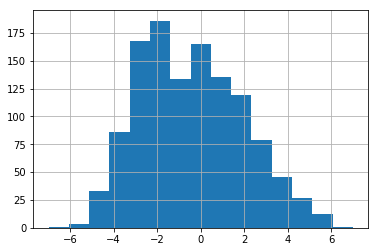

In [21]:
data['Points'].hist(bins=15)
plt.show()

In [22]:
len(data)

1195

In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [36]:
data = data.assign(Margin=(data['FairPrice']/data['Price'] -1 )*100)

In [38]:
data[['Name', 'ISIN', 'FairPrice', 'FairPricePE', 'Price', 'Margin', 'Points']]

,Name,ISIN,FairPrice,FairPricePE,Price,Margin,Points
216,FUCHS PETROL.SE VZO O.N.,DE0005790430,29.13,34.13,47.50,-38.67,7.00
960,"INTL FLAVORS/FRAG.DL-,125",US4595061015,75.89,98.53,140.56,-46.01,6.00
955,INFOSYS LTD. ADR/1 IR5,US4567881085,727.32,0.00,14.23,5009.41,6.00
1102,"ROSS STRS INC. DL-,01",US7782961038,43.88,46.39,10.14,332.78,6.00
574,"RECKITT BENCK.GRP LS -,10",GB00B24CGK77,51.00,0.00,79.30,-35.69,6.00
1170,"WATERS CORP. DL-,01",US9418481035,89.04,104.70,144.89,-38.55,6.00
85,"SIKA AG INH. SF 0,60",CH0000587979,3022.39,4484.83,6800.00,-55.55,6.00
922,"GILEAD SCIENCES DL-,001",US3755581036,238.66,225.37,54.66,336.63,6.00
567,"EXPERIAN PLC DL -,10",GB00B19NLV48,11.35,0.00,16.63,-31.74,6.00
1150,USANA HEALTH,US90328M1071,54.10,79.23,54.88,-1.42,6.00


# Calculate maximum drawdown 

In [6]:
s.get_highwatermark()

AttributeError: 'stock' object has no attribute 'get_highwatermark'

In [87]:
hwratio = s.quote.close/s.quote.highwatermark

In [88]:
hwratio.describe()

count    4360.000000
mean        0.880524
std         0.132514
min         0.309044
25%         0.843490
50%         0.914717
75%         0.972077
max         1.000000
dtype: float64

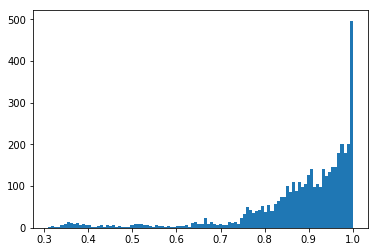

In [89]:
plt.hist(hwratio[hwratio>0],bins=100)
plt.show()

# Backtesting

In [260]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
0,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2006,156.0,1323.0,96.0,11.29,0.62,0.13,...,NaN,169.0,64.72,34.94,7.30,1.93,14.08,2.25,29.47,25.10
1,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2007,154.0,1365.0,119.0,13.67,0.77,0.17,...,0.47,154.0,62.70,35.57,8.76,1.96,17.14,2.13,36.08,17.67
2,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2008,147.0,1394.0,109.0,11.68,0.74,0.25,...,0.82,121.0,64.98,32.25,7.85,1.96,15.42,2.24,28.76,21.87
3,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2009,142.0,1178.0,120.0,14.68,0.84,0.27,...,0.41,239.0,61.20,29.79,10.25,1.63,16.67,1.90,27.68,35.58
4,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2010,142.0,1458.0,170.0,16.82,1.20,0.29,...,1.00,286.0,61.13,30.07,11.70,1.78,20.82,1.64,33.91,82.80
5,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2011,142.0,1652.0,182.0,15.73,1.28,0.45,...,0.94,315.0,63.39,29.66,10.93,1.77,19.37,1.51,29.65,97.41
6,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2012,142.0,1819.0,206.0,16.00,1.45,0.50,...,0.82,395.0,63.39,28.86,11.36,1.73,19.69,1.42,28.27,NaN
7,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2013,142.0,1831.0,218.0,16.96,1.53,0.65,...,1.02,426.0,62.33,29.64,11.91,1.61,19.21,1.36,26.45,NaN
8,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2014,139.0,1866.0,220.0,16.62,1.57,0.70,...,1.16,458.0,62.85,29.09,11.76,1.53,18.01,1.40,24.51,NaN
9,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2015,139.0,2079.0,236.0,16.26,1.69,0.77,...,1.58,430.0,61.95,30.22,11.34,1.50,17.05,1.39,23.63,NaN


In [265]:
s.update_time(1120)
print(s.bdate)

2002-04-09


In [266]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
16,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,2000,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,1999,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
s.update_time(1100)
print(s.bdate)

2002-03-20


In [268]:
s.keyratios

,name,ISIN,currency,year,Shares,Revenue,NetIncome,EBTMargin,EarningsPerShare,Dividends,...,FreeCashFlowPerShare,WorkingCapital,COGS,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
17,FUCHS PETROL.SE VZO O.N.,DE0005790430,EUR,1999,NaN,NaN,NaN,NaN,0.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
